<a href="https://colab.research.google.com/github/lukasfebri015/Semester4/blob/main/Tugas_Codingan_Sesi_13_AI_20220040076_LUKASFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu
[Epoch 0/2] [Batch 0/235] [D loss: 0.6969730854034424] [G loss: 0.7220830917358398]
[Epoch 0/2] [Batch 1/235] [D loss: 0.6186376810073853] [G loss: 0.705099880695343]
[Epoch 0/2] [Batch 2/235] [D loss: 0.5592958927154541] [G loss: 0.6905829906463623]
[Epoch 0/2] [Batch 3/235] [D loss: 0.5182003378868103] [G loss: 0.6713370084762573]
[Epoch 0/2] [Batch 4/235] [D loss: 0.49309438467025757] [G loss: 0.6497727036476135]
[Epoch 0/2] [Batch 5/235] [D loss: 0.48733431100845337] [G loss: 0.6201030611991882]
[Epoch 0/2] [Batch 6/235] [D loss: 0.49781379103660583] [G loss: 0.5897089838981628]
[Epoch 0/2] [Batch 7/235] [D loss: 0.5277219414710999] [G loss: 0.5510354042053223]
[Epoch 0/2] [Batch 8/235] [D loss: 0.5598625540733337] [G loss: 0.5194641947746277]
[Epoch 0/2] [Batch 9/235] [D loss: 0.5758686065673828] [G loss: 0.5082681179046631]
[Epoch 0/2] [Batch 10/235] [D loss: 0.5783339142799377] [G loss: 0.5132440328598022]
[Epoch 0/2] [Batch 11/235] [D loss: 0.5674668550491333]

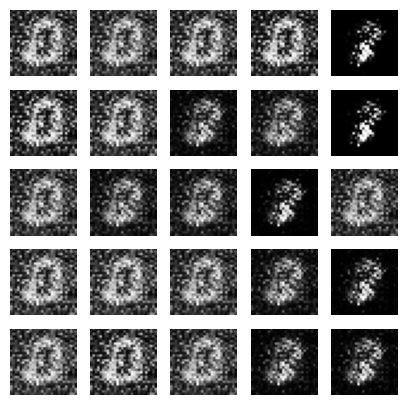

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os
from torch.cuda.amp import GradScaler, autocast

# Hyperparameters
latent_dim = 1
batch_size = 256  # Increase batch size
lr = 0.0002
num_epochs = 2
image_size = 28
channels = 1

# Create directory to save generated images
os.makedirs("images", exist_ok=True)

# Transformations
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load the dataset
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, image_size * image_size),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.main(z)
        img = img.view(img.size(0), channels, image_size, image_size)
        return img

# Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(image_size * image_size, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.main(img_flat)
        return validity

# Check if CUDA is available and move models to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss function and optimizers
adversarial_loss = nn.BCELoss().to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Mixed precision training
scaler = GradScaler()

# Training
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Move images to GPU if available
        imgs = imgs.to(device)

        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1).to(device)
        fake = torch.zeros(imgs.size(0), 1).to(device)

        # Configure input
        real_imgs = imgs

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.randn(imgs.size(0), latent_dim).to(device)

        # Generate a batch of images
        with autocast():
            gen_imgs = generator(z)
            g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        # Backward and optimize
        scaler.scale(g_loss).backward()
        scaler.step(optimizer_G)
        scaler.update()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Disable gradient computation for discriminator
        with torch.no_grad():
            fake_imgs = generator(z).detach()

        # Measure discriminator's ability to classify real from generated samples
        with autocast():
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(fake_imgs), fake)
            d_loss = (real_loss + fake_loss) / 2

        # Backward and optimize
        scaler.scale(d_loss).backward()
        scaler.step(optimizer_D)
        scaler.update()

        print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

    # Save generated images every epoch
    save_image(gen_imgs.data[:25], f"images/{epoch}.png", nrow=5, normalize=True)

# Generate a single image
z = torch.randn(1, latent_dim).to(device)
single_image = generator(z).detach()  # Remove the conversion to NumPy array

# Save the single image
save_image(single_image, "69840153_p0.jpg", normalize=True)

# Plot some generated images
def show_generated_images():
    fig, ax = plt.subplots(5, 5, figsize=(5, 5))
    for i in range(5):
        for j in range(5):
            ax[i, j].imshow(gen_imgs[i*5 + j].cpu().detach().numpy().reshape(28, 28), cmap='gray')
            ax[i, j].axis('off')
    plt.show()

show_generated_images()